# **import essential libraries**

In [ ]:
from google.colab import drive
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
!pip install transformers
from transformers import BertTokenizer, BertModel
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.6 MB/s eta 0:00:00


# **Read the Dataset**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/netflix.csv'
df = pd.read_csv(dataset_path)

# **Preprocessing**

**analyze dataset**

In [ ]:
def analyzeDataset():
    missing_values = df.isnull().sum()
    fig, ax = plt.subplots(figsize=(12, 6))
    missing_values.plot.bar(ax=ax)
    for i, val in enumerate(missing_values):
        ax.text(i, val + 10, str(val), ha='center', fontweight='bold')

    plt.show()

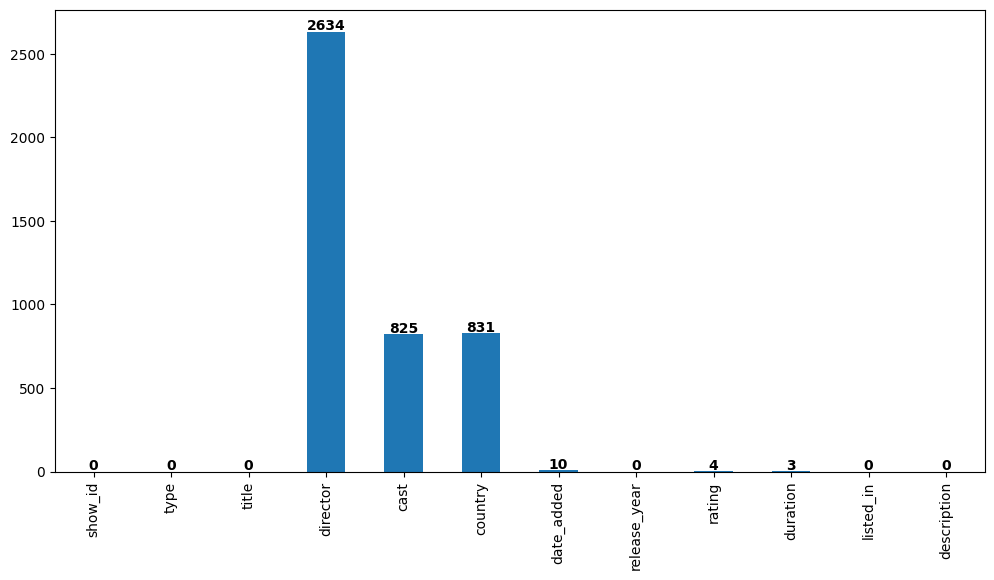

In [ ]:
analyzeDataset()

**delete useless columns**

In [ ]:
df.drop('date_added', axis=1, inplace=True)
df.drop('rating', axis=1, inplace=True)
df.drop('country', axis=1, inplace=True)

**fill missing data with forward fill**

In [ ]:
df['duration'].fillna(method="ffill", inplace=True)

**delete bullshit rows**

counting the number of records which both 'cast' and 'director' columns are empty.

In [ ]:
counter = 0
for index, row in df.iterrows():
  if pd.isnull(row['cast']) and pd.isnull(row['director']):
    counter += 1

counter  #352 item

352

In [ ]:
df.dropna(subset=['director'], how='all', inplace=True)

**get missing data from OMDB API**

in this section, we use the api of OMDB website to get the informatio of a show/movie. but since there's a limit on api requests (1000 requests per day), we couldn't use this method.

In [ ]:
api_key = '879de04b'
counter = 0
for index, row in df.iterrows():
  if counter == 1000:
    break
  if pd.isnull(row['country']) or pd.isnull(row['cast']) or pd.isnull(row['director']):
    title = row['title']
    url = f'http://www.omdbapi.com/?apikey={api_key}&t={title}'

    response = requests.get(url)
    if response.status_code == 200:
      movie_data = response.json()
      if pd.isnull(row['cast']) and 'Actors' in movie_data:
        df.at[index, 'cast'] = movie_data['Actors']
      if pd.isnull(row['director']) and 'Director' in movie_data:
        df.at[index, 'director'] = movie_data['Director']

  counter += 1

**plot outliers**

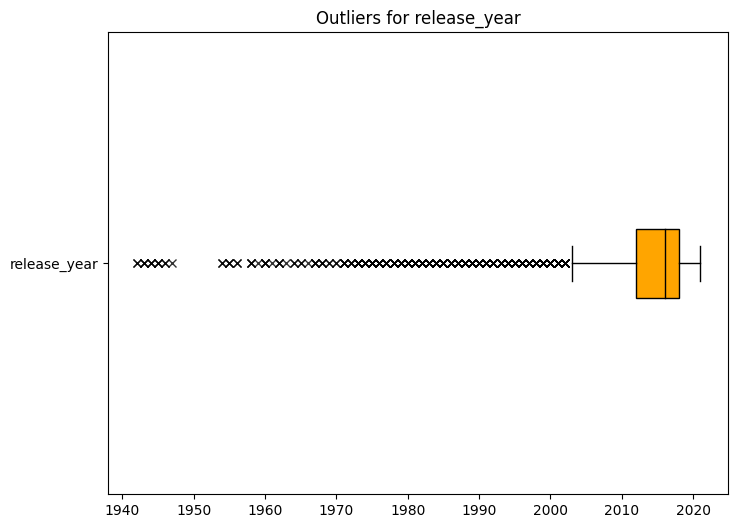

In [ ]:
numeric_fields = ['release_year']

plt.figure(figsize=(8, 6))

# Boxplot for each numeric field
for field in numeric_fields:
    boxplot = plt.boxplot(df[field], vert=False, labels=[field], patch_artist=True)
    box_color = 'orange'
    for box in boxplot['boxes']:
        box.set_facecolor(box_color)
    plt.setp(boxplot['whiskers'], color='black')
    plt.setp(boxplot['caps'], color='black')
    plt.setp(boxplot['medians'], color='black')

    for flier in boxplot['fliers']:
        flier.set(marker='x', alpha=0.8)

    plt.title(f'Outliers for {field}')
    plt.show()


**delete outliers based on release years**

In [ ]:
for field in numeric_fields:
    q1 = df[field].quantile(0.25)
    q3 = df[field].quantile(0.75)
    iqr = q3 - q1
    threshold = 1.5 * iqr

    lower_bound = q1 - threshold
    upper_bound = q3 + threshold
    print(lower_bound, upper_bound)

    # field_outliers = df[(df[field] < lower_bound) | (df[field] > upper_bound)]

    df = df[(df[field] >= lower_bound) & (df[field] <= upper_bound)]


# field_outliers.shape    #718 - (low: 2003, upper: 2028)


2003.0 2027.0


In [ ]:
df['release_year'].min()

2003

**convert numerical to categorical**

In [ ]:
bins = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '2000s', '2010s', '2020s']

df['release_year'] = pd.cut(df['release_year'], bins=bins, labels=labels)

**plot release year**

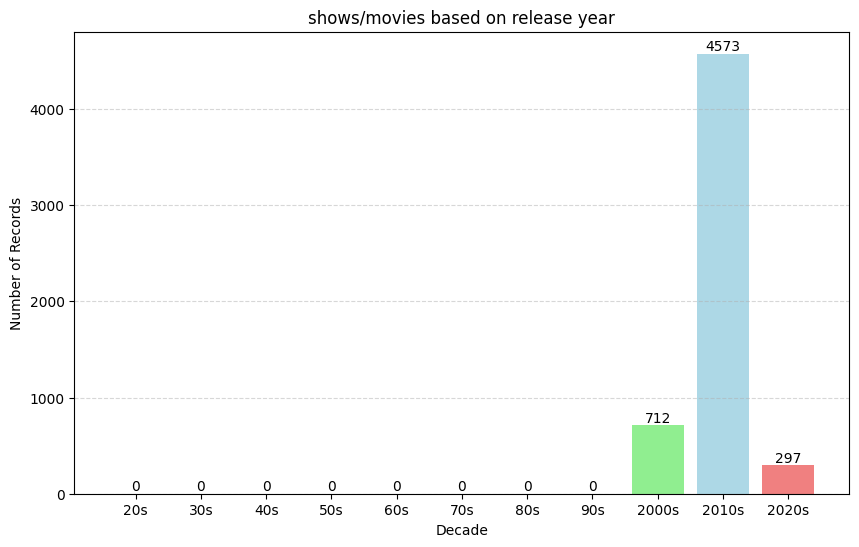

In [ ]:
decade_counts = df['release_year'].value_counts().sort_index()

# Define colors for each bar
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightsalmon', 'yellow',
          'lightcyan', 'lightgrey', 'lightgreen', 'lightblue', 'lightcoral']

plt.figure(figsize=(10, 6))
bars = plt.bar(decade_counts.index, decade_counts.values, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom')

plt.xlabel('Decade')
plt.ylabel('Number of Records')
plt.title('shows/movies based on release year')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


**preprocess text (stemmer, lemmatizer)**

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = text.lower().split()  # Tokenization and lowercase
    tokens = [token for token in tokens if token not in stop_words]  # Stopword removal
    tokens = [stemmer.stem(token) for token in tokens]  # Stemming
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatizing (alternative to stemming)
    return ' '.join(tokens)

text_fields = ['description']
for field in text_fields:
    df[field] = df[field].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print(df.loc[0, 'description'])

father near end life, filmmak kirsten johnson stage death invent comic way help face inevitable.


In [ ]:
df['director'].fillna('unknown', inplace=True)
df['cast'].fillna('unknown', inplace=True)
# analyzeDataset()

In [ ]:
director_counts = df['director'].value_counts()
average_films = director_counts.mean()
average_films

1.3227488151658768

In [ ]:
director_counts = df['director'].value_counts()
average_films = director_counts.mean()

director_stats = []

for director, count in director_counts.items():
    if count > average_films:
        status = 'Above Average'
    elif count < average_films:
        status = 'Below Average'
    else:
        status = 'Average'

    director_stats.append({
        'Director': director,
        'Number of Movies': count,
        'Above/Below Average': status
    })

director_stats = pd.concat([pd.DataFrame(director_stats)], ignore_index=True)

In [ ]:
director_stats[650:]

,Director,Number of Movies,Above/Below Average
650,Israel Adrián Caetano,2,Above Average
651,Claire Scanlon,2,Above Average
652,Vipul Amrutlal Shah,2,Above Average
653,Alastair Fothergill,2,Above Average
654,Kim Joo-hyung,2,Above Average
...,...,...,...
4215,Eva Orner,1,Below Average
4216,KVR Mahendra,1,Below Average
4217,Juan Carlos Rulfo,1,Below Average
4218,Raj R,1,Below Average


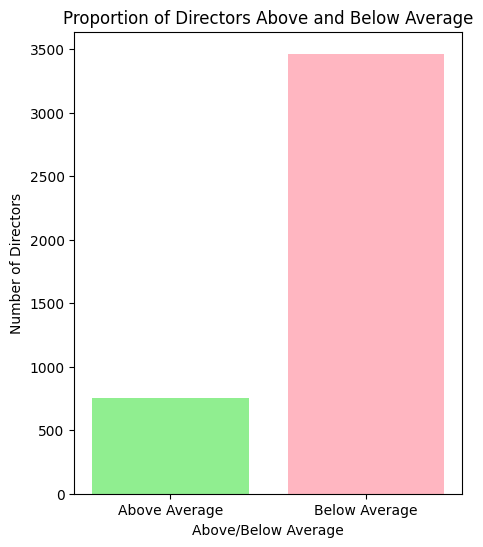

In [ ]:
# Calculate the counts of directors above and below average
above_average_count = len(director_stats[director_stats['Above/Below Average'] == 'Above Average'])
below_average_count = len(director_stats[director_stats['Above/Below Average'] == 'Below Average'])

bar_colors = ['lightgreen', 'lightpink']

plt.figure(figsize=(5, 6))
plt.bar(['Above Average', 'Below Average'], [above_average_count, below_average_count], color=bar_colors)
plt.xlabel('Above/Below Average')
plt.ylabel('Number of Directors')
plt.title('Proportion of Directors Above and Below Average')

plt.show()


# **Phase 2**

In [ ]:
!pip install mlxtend

In [ ]:
df['listed_in'].unique()

array(['Documentaries',
       'Crime TV Shows, International TV Shows, TV Action & Adventure',
       'TV Dramas, TV Horror, TV Mysteries', 'Children & Family Movies',
       'British TV Shows, Reality TV', 'Comedies, Dramas',
       'Dramas, International Movies',
       'Children & Family Movies, Comedies',
       'Documentaries, International Movies', 'Thrillers',
       'Crime TV Shows, Docuseries, International TV Shows', 'Comedies',
       'Horror Movies, Sci-Fi & Fantasy',
       'Dramas, Independent Movies, International Movies',
       'Dramas, International Movies, Thrillers',
       'Action & Adventure, Dramas, International Movies',
       'Action & Adventure, Dramas', 'Action & Adventure',
       'International TV Shows, Romantic TV Shows, TV Comedies',
       'Action & Adventure, Anime Features, International Movies',
       'Documentaries, International Movies, Sports Movies',
       'Comedies, Dramas, International Movies',
       'Action & Adventure, Comedies, Dramas'

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Filter out rows with 'unknown' values in 'director' and 'cast' columns
filtered_df = df[(df['director'] != 'unknown') & (df['cast'] != 'unknown')]

subset_df = filtered_df[['director', 'cast', 'listed_in']]

# Convert the subset dataframe to a list of lists and convert values to strings
transactionsList = subset_df.astype(str).values.tolist()

transactions = []
for transaction in transactionsList:
    cast_list = transaction[1].split(', ')  # Split the cast names by comma and space
    listed_in_list = transaction[2].split(', ')  # Split the listed_in categories by comma and space
    transactions.append([transaction[0]] + cast_list + listed_in_list)

# Apply one-hot encoding to convert the transaction list to a transaction matrix
te = TransactionEncoder()
te_array = te.fit_transform(transactions)
transaction_matrix = pd.DataFrame(te_array, columns=te.columns_)

# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(transaction_matrix, min_support=0.05, use_colnames=True)

# Display the frequent itemsets
frequent_itemsets


,support,itemsets
0,0.131980,(Action & Adventure)
1,0.104061,(Children & Family Movies)
2,0.280750,(Comedies)
3,0.078290,(Documentaries)
4,0.417220,(Dramas)
5,0.063452,(Horror Movies)
6,0.138227,(Independent Movies)
7,0.458805,(International Movies)
8,0.056619,(Music & Musicals)
9,0.106404,(Romantic Movies)


In [ ]:
for index, row in frequent_itemsets.iterrows():
    itemset = row['itemsets']
    support = row['support']
    print(f"Itemset: {itemset}, Support: {support}")


Itemset: frozenset({'Action & Adventure'}), Support: 0.1319796954314721
Itemset: frozenset({'Children & Family Movies'}), Support: 0.10406091370558376
Itemset: frozenset({'Comedies'}), Support: 0.28074970714564623
Itemset: frozenset({'Documentaries'}), Support: 0.07828973057399453
Itemset: frozenset({'Dramas'}), Support: 0.4172198360015619
Itemset: frozenset({'Horror Movies'}), Support: 0.06345177664974619
Itemset: frozenset({'Independent Movies'}), Support: 0.138227254978524
Itemset: frozenset({'International Movies'}), Support: 0.4588051542366263
Itemset: frozenset({'Music & Musicals'}), Support: 0.05661850839515814
Itemset: frozenset({'Romantic Movies'}), Support: 0.10640374853572823
Itemset: frozenset({'Stand-Up Comedy'}), Support: 0.058961343225302616
Itemset: frozenset({'Thrillers'}), Support: 0.105232331120656
Itemset: frozenset({'Action & Adventure', 'International Movies'}), Support: 0.06423272159312768
Itemset: frozenset({'Dramas', 'Comedies'}), Support: 0.08648965247950019
I

In [ ]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

In [ ]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Comedies),(International Movies),0.280750,0.458805,0.142718,0.508345,1.107976,0.013908,1.100761
1,(Independent Movies),(Dramas),0.138227,0.417220,0.107575,0.778249,1.865320,0.049904,2.628079
2,(Dramas),(International Movies),0.417220,0.458805,0.262202,0.628451,1.369756,0.070780,1.456591
3,(International Movies),(Dramas),0.458805,0.417220,0.262202,0.571489,1.369756,0.070780,1.360013
4,(Romantic Movies),(International Movies),0.106404,0.458805,0.065795,0.618349,1.347737,0.016976,1.418035


# **Phase 3**

In [ ]:
!pip install transformers
!pip install torch
!pip install transformers
!pip install sentence-transformers
from transformers import BertTokenizer, BertModel
import torch
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=28dfc81d99bd1850636ffec7b082e17bffc93964f385d12ed41032860d0e30db
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
model = SentenceTransformer('bert-base-uncased')
descriptions = df['description'].tolist()
description_vectors = model.encode(descriptions)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(description_vectors)
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(description_vectors)
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=cluster_labels)
plt.title('BERT Sentence Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [ ]:
model_name = 'bert-base-uncased'  # Choose the desired BERT model, e.g., 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
descriptions = df['description'].tolist()
encoded_inputs = tokenizer(descriptions, padding=True, truncation=True, max_length=512, return_tensors='pt')
with torch.no_grad():
    outputs = model(**encoded_inputs)

embeddings = outputs.last_hidden_state


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Add embeddings to the DataFrame
df['embeddings'] = embeddings.tolist()

In [ ]:
from sklearn.decomposition import PCA

# Reshape 'embeddings' to have two dimensions
embeddings_reshaped = embeddings.reshape(embeddings.shape[0], -1)

# Apply PCA to reduce the dimensionality to two dimensions
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_reshaped)


In [ ]:
unique_listed_in = np.unique(df['listed_in'])

new_array = np.array([])

for item in unique_listed_in:
    split_items = item.split(', ')
    new_array = np.append(new_array, split_items)


unique_values = np.unique(new_array)
num_unique_values = len(unique_values)

print("Number of unique values:", num_unique_values)

Number of unique values: 42


In [ ]:
unique_values

array(['Action & Adventure', 'Anime Features', 'Anime Series',
       'British TV Shows', 'Children & Family Movies',
       'Classic & Cult TV', 'Classic Movies', 'Comedies',
       'Crime TV Shows', 'Cult Movies', 'Documentaries', 'Docuseries',
       'Dramas', 'Faith & Spirituality', 'Horror Movies',
       'Independent Movies', 'International Movies',
       'International TV Shows', "Kids' TV", 'Korean TV Shows',
       'LGBTQ Movies', 'Movies', 'Music & Musicals', 'Reality TV',
       'Romantic Movies', 'Romantic TV Shows', 'Sci-Fi & Fantasy',
       'Science & Nature TV', 'Spanish-Language TV Shows',
       'Sports Movies', 'Stand-Up Comedy', 'Stand-Up Comedy & Talk Shows',
       'TV Action & Adventure', 'TV Comedies', 'TV Dramas', 'TV Horror',
       'TV Mysteries', 'TV Sci-Fi & Fantasy', 'TV Shows', 'TV Thrillers',
       'Teen TV Shows', 'Thrillers'], dtype='<U32')

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

# Flatten the embeddings array to 2D
num_samples, num_features = embeddings.shape[0], np.prod(embeddings.shape[1:])
embeddings_2d = embeddings.reshape(num_samples, num_features)

# Reduce the dimensionality of 'embeddings' using t-SNE
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings_2d)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust the parameters as needed
clusters = dbscan.fit_predict(embeddings_2d)

# Plot the data points with different colors for each cluster
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"Number of clusters: {num_clusters}")

Number of clusters: 11


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Reshape 'embeddings' to have two dimensions
embeddings_reshaped = embeddings.reshape(embeddings.shape[0], -1)

# Apply PCA to reduce the dimensionality to two dimensions
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_reshaped)

# Perform K-means clustering on the reduced-dimensional data
kmeans = KMeans(n_clusters=11)
clusters = kmeans.fit_predict(embeddings_2d)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


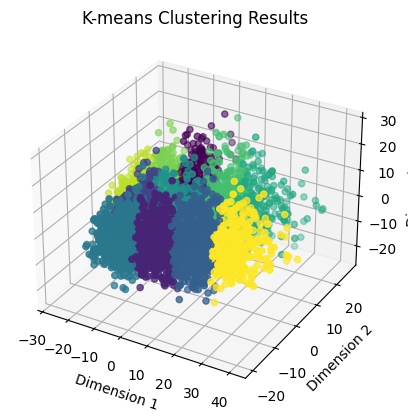

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reshape 'embeddings' to have three dimensions
embeddings_reshaped = embeddings.reshape(embeddings.shape[0], -1)

# Apply PCA to reduce the dimensionality to three dimensions
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings_reshaped)

# Visualize the clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=clusters, cmap='viridis')

# Set labels and title
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('K-means Clustering Results')

plt.show()

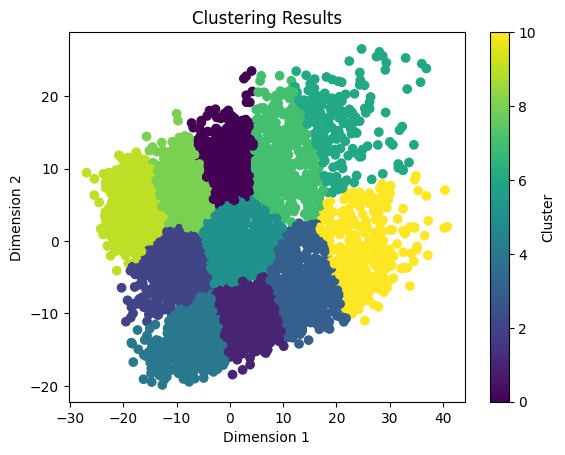

In [ ]:
# Plot the data points with different colors for each cluster
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering Results')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Cluster')
plt.show()


**classification**

In [ ]:
# Extract the first genre from the 'listed_in' column
df['label'] = df['listed_in'].str.split(',').str[0].str.strip()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Prepare the Data
X = embeddings  # BERT embeddings for film descriptions
y = df['listed_in']  # Target Variable: Listed_in (Genre)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Classification Model (Logistic Regression)
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the Model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Predict the Genre for a Film
film_description = "This film is a thrilling crime drama set in a futuristic city."
film_embedding = # Obtain BERT embedding for the film description
predicted_genre = model.predict(np.array([film_embedding]))
print("Predicted Genre:", predicted_genre)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Assume you have a DataFrame called 'df' with 'description' and 'listed_in' columns
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['listed_in'], test_size=0.2, random_state=42)

# Reshape the X_train array to have 2 dimensions
X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Create the multi-label binarizer for the labels
mlb = MultiLabelBinarizer()
y_train_binary = mlb.fit_transform(y_train)
y_test_binary = mlb.transform(y_test)

# Train the multi-label classifier
classifier = MultiOutputClassifier(LinearSVC())
classifier.fit(X_train_2d, y_train_binary)

# Predict the genres for the test set
X_test_2d = X_test.reshape(X_test.shape[0], -1)
y_pred_binary = classifier.predict(X_test_2d)

# Convert the binary predictions back to genre labels
y_pred = mlb.inverse_transform(y_pred_binary)

# Evaluate the performance of the classifier
print(classification_report(y_test, y_pred))


In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel

# Extract the first genre from the 'listed_in' column
df['label'] = df['listed_in'].str.split(',').str[0].str.strip()

# Prepare data for classification
X = embeddings  # Input features (BERT embeddings)
y = df['label']  # Target variable (genre label)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:

# Extract the first genre from the 'listed_in' column
df['label'] = df['listed_in'].str.split(',').str[0].str.strip()

In [ ]:
df[:10]

In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel


In [ ]:
# Prepare data for classification
X = np.array(embeddings.tolist())  # Input features (BERT embeddings)
y = df['label']  # Target variable (genre label)

In [ ]:
# Apply dimensionality reduction using PCA
pca = PCA(n_components=50)  # Specify the desired number of components
X_reduced = pca.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))